In the last post we looked at the distribution of eigenvalues of the Laplace operator; this time we'll look at eigenfunctions.
As a reminder, a function $\phi$ and a real number $\lambda$ are an eigenfunction and eigenvalue of the Laplace operator on a domain $\Omega$ if

$$-\Delta\phi = \lambda^2\phi$$

together with the Dirichlet boundary condition $\phi|_{\partial\Omega} = 0$.
I'm using a slightly different convention that emphasizes the positivity of the Laplace operator, and which gives the eigenvalues $\lambda$ units of an inverse length.

The eigenfunctions grow more and more oscillatory for larger values of $\lambda$ and there are number of results that quantify this idea.
A classical result is the *Courant nodal domain theorem*.
The nodal domain theorem states that the zero set of the $n$-th eigenfunction of the Laplace operator divides the domain into at most $n$ regions, although the number of nodal domains can be less than $n$.
Highly symmetric domains like the sphere or the torus provide interesting cases because, for these kinds of domains, you tend to get very degenerate eigenspaces.
The Courant nodal domain theorem only gives a kind of upper bound on how oscillatory the eigenfunctions get, not a lower bound.

To refine the concept a bit further, we'll do a little experiment to verify the *Yau conjecture*.
The Yau conjecture states that, as $\lambda \to \infty$, the area of the nodal set of $\phi_\lambda$ is bounded above and below a multiple of $\lambda$:

$$c\lambda \le \text{area}(\{\phi_\lambda = 0\}) \le C\lambda.$$

Donnelly and Fefferman proved the Yau conjecture for analytic manifolds (with and without boundary) in 1990.
For smooth manifolds, Logunov announced a [proof](https://arxiv.org/abs/1605.02589) of the lower bound in May of 2019, but as far as I know the upper bound hasn't been resolved yet.

In [1]:
import gmsh
import numpy as np
from numpy import pi as π

gmsh.initialize()
geo = gmsh.model.geo

Lx, Ly = 2.0, 1.0
lcar = 1.0 / 16
origin = geo.add_point(0, 0, 0, lcar)
points = [
    geo.add_point(Lx, 0, 0, lcar),
    geo.add_point(0, Ly, 0, lcar),
    geo.add_point(-Lx, 0, 0, lcar),
    geo.add_point(0, -Ly, 0, lcar),
]
major = points[0]

outer_arcs = [
    geo.add_ellipse_arc(p1, origin, major, p2)
    for p1, p2 in zip(points, np.roll(points, 1))
]

geo.add_physical_group(1, outer_arcs)
outer_curve_loop = geo.add_curve_loop(outer_arcs)

centers = np.array([(0, 1/2), (1/2, 1/4), (1, -1/4)])
radii = [1/8, 3/16, 1/4]
hole_curve_loops = []
for center, radius in zip(centers, radii):
    hole_center = geo.add_point(*center, 0, lcar)
    deltas = np.array([(1, 0), (0, 1), (-1, 0), (0, -1)])
    hole_points = [
        geo.add_point(*(center + radius * delta), 0, lcar) for delta in deltas
    ]
    hole_arcs = [
        geo.add_circle_arc(p1, hole_center, p2)
        for p1, p2 in zip(hole_points, np.roll(hole_points, 1))
    ]
    geo.add_physical_group(1, hole_arcs)
    curve_loop = geo.add_curve_loop(hole_arcs)
    hole_curve_loops.append(curve_loop)

plane_surface = geo.add_plane_surface([outer_curve_loop] + hole_curve_loops)
geo.add_physical_group(2, [plane_surface])
geo.synchronize()

gmsh.model.mesh.generate(2)
gmsh.write("ellipse.msh")

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 10%] Meshing curve 2 (Ellipse)
Info    : [ 20%] Meshing curve 3 (Ellipse)
Info    : [ 20%] Meshing curve 4 (Ellipse)
Info    : [ 30%] Meshing curve 5 (Circle)
Info    : [ 40%] Meshing curve 6 (Circle)
Info    : [ 40%] Meshing curve 7 (Circle)
Info    : [ 50%] Meshing curve 8 (Circle)
Info    : [ 60%] Meshing curve 9 (Circle)
Info    : [ 60%] Meshing curve 10 (Circle)
Info    : [ 70%] Meshing curve 11 (Circle)
Info    : [ 70%] Meshing curve 12 (Circle)
Info    : [ 80%] Meshing curve 13 (Circle)
Info    : [ 90%] Meshing curve 14 (Circle)
Info    : [ 90%] Meshing curve 15 (Circle)
Info    : [100%] Meshing curve 16 (Circle)
Info    : Done meshing 1D (Wall 0.012707s, CPU 0.014205s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0779601s, CPU 0.07451s)
Info    : 2171 nodes 4358 elements
Info    : Writing 'ellipse.msh'...
Info    : Done writing 'ellip

In [2]:
import firedrake
mesh = firedrake.Mesh('ellipse.msh')

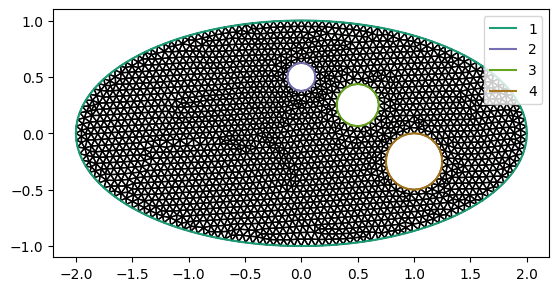

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
firedrake.triplot(mesh, axes=axes)
axes.set_aspect("equal")
axes.legend(loc="upper right");

In [4]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
ϕ = firedrake.TestFunction(Q)
ψ = firedrake.TrialFunction(Q)

from firedrake import inner, grad, dx
a = inner(grad(ϕ), grad(ψ)) * dx
m = ϕ * ψ * dx

bc = firedrake.DirichletBC(Q, 0, 'on_boundary')
A = firedrake.assemble(a, bcs=bc).M.handle
M = firedrake.assemble(m).M.handle

Setting up the eigensolver is the same as before.

In [5]:
from petsc4py import PETSc
opts = PETSc.Options()
opts.setValue('eps_gen_hermitian', None)
opts.setValue('eps_target_real', None)
opts.setValue('eps_smallest_real', None)
opts.setValue('st_type', 'sinvert')
opts.setValue('st_ksp_type', 'cg')
opts.setValue('st_pc-type', 'jacobi')
opts.setValue('eps_tol', 1e-8)

In [6]:
from slepc4py import SLEPc
num_values = 250
eigensolver = SLEPc.EPS().create(comm=firedrake.COMM_WORLD)
eigensolver.setDimensions(num_values)
eigensolver.setOperators(A, M)
eigensolver.setFromOptions()
eigensolver.solve()

In [7]:
num_converged = eigensolver.getConverged()
print(num_converged)

295


Now we need to use a bit of trickery to calculate the area of the zero contours:

$$\text{area}(\{\phi_\lambda = 0\}) = \int_{\{\phi_\lambda = 0\}}ds.$$

Firedrake doesn't have built-in support for integrating over interior contours of a domain that aren't already predefined when the mesh was generated, so we'll have to do something a little indirect.
To evaluate this integral, I'll use the fact that the gradient of a smooth function is always perpendicular to its level sets.
In particular, if $\nu$ is the unit outward normal vector to the super-level set $\{\phi_\lambda \ge 0\}$ and $u$ is any vector field such that $u \cdot \nu = 1$ along the region $\{\phi_\lambda = 0\}$, then

$$\int_{\{\phi_\lambda = 0\}}ds = \int_{\{\phi_\lambda = 0\}}u\cdot\nu\; ds = \int_{\{\phi_\lambda \ge 0\}}\nabla\cdot u\; dx.$$

Now we know that

$$\nu = -\frac{\nabla\phi_\lambda}{|\nabla\phi_\lambda|},$$

so it's enough to take

$$u = -\frac{\nabla\phi_\lambda}{|\nabla\phi_\lambda|}.$$

This vector field is well-defined except at critical points of the eigenfunction.
If we wanted to be extra careful we could include a fudge factor somewhere in the denominator, but that doesn't seem to be necessary to get a sensible answer.

In [8]:
from firedrake import sqrt, div, dS
ϕ = firedrake.Function(Q)
sign = firedrake.conditional(ϕ >= 0, 1, 0) - firedrake.conditional(ϕ <= 0, 1, 0)
u = -grad(ϕ) / sqrt(inner(grad(ϕ), grad(ϕ))) * sign
ν = firedrake.FacetNormal(mesh)
J = 0.5 * div(u) * dx

lengths = np.zeros(num_values)
for index in range(num_values):
    Vr, Vi = A.getVecs()
    λ = eigensolver.getEigenpair(index, Vr, Vi)
    ϕ.vector()[:] = Vr
    lengths[index] = firedrake.assemble(J)

In [9]:
Es = np.array([eigensolver.getEigenvalue(k) for k in range(num_values)]).real
λs = np.sqrt(Es)

The plot of the wavenumber against the lengths of the nodal sets looks pretty close to linear in the eyeball norm!

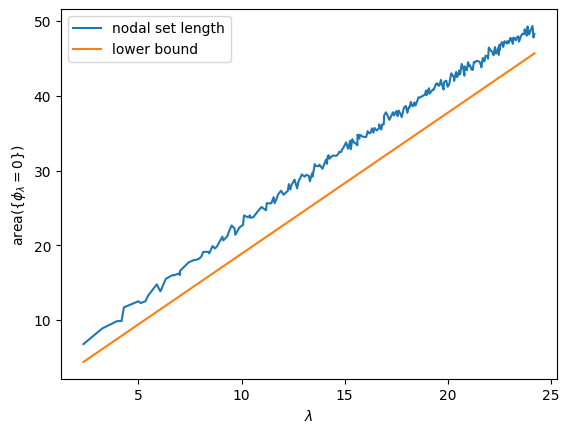

In [10]:
area = firedrake.assemble(firedrake.Constant(1) * dx(mesh))

import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(λs, lengths, label='nodal set length')
axes.plot(λs, λs * area / π, label='lower bound')
axes.legend()
axes.set_xlabel('$\lambda$')
axes.set_ylabel('area($\{\phi_\lambda = 0\}$)');

I made a bit of a wild guess here for what the lower bound $c$ is.
The area of the nodal sets has units of length${}^{d - 1}$ and the eigenvalues $\lambda$ have units of length${}^{-1}$.
So for the constants $c, C$ to be dimensionally correct, they would need to have units of length${}^d$, which suggests that they're proportional to the volume of the domain.
I get a pretty reasonable lower bound by dividing by $\pi$, which of course happens to be the volume of the unit disk in $\mathbb{R}^2$.
It would be a fun experiment to see how well this holds up for other domains or higher dimensions.